## **Problem statement:** 
#### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### ***Solution Steps:***
1. Data Reading/Data Understanding (Importing Skin Cancer ISIC Data)
2. Dataset Creation
3. Dataset Visualisation
4. Model Building & Training (1st Model)
5. Choose an appropriate data augmentation strategy to resolve underfitting/overfitting
6. Model Building & training on the augmented data (2nd Model)
7. Class distribution
8. Handling class imbalances
9. Model Building & training on the rectified class imbalance data (3rd Model)
10. Model Evaluation

### Data Reading/Data Understanding (Importing Skin Cancer ISIC Data)

#### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from glob import glob
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom,RandomContrast
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models

!pip install Augmentor
import Augmentor

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install --upgrade Pillow

In [3]:
import pathlib
from PIL import Image

# Root directory
root_dir = pathlib.Path('/Users/rakes/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration')

# Check if the root directory exists
if not root_dir.exists():
    print(f"Directory (root_dir) doesn't exist.")

data_dir_train = root_dir / 'Train'
data_dir_test = root_dir / 'Test'

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

#### **Dataset Creation**

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

#### Use 80% of the images for training, and 20% for validation.

In [6]:
## Defining train dataset, using the seed =123 and resizing image as img_height*img_width

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Defining test dataset, using the seed =123 and resizing image as img_height*img_width

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listing out all the classes of skin cancer and store them in a list and arranging them in alphabetical order

class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print("Total Number of classes : ", num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Total Number of classes :  9


### **Dataset Visualisation**

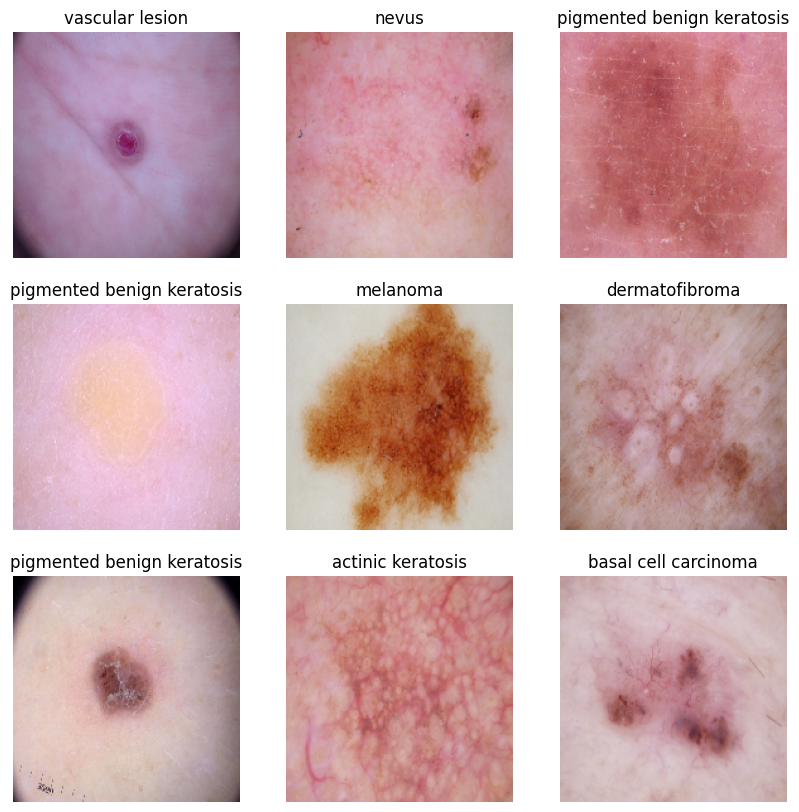

In [9]:
### Visualizing all the classes 

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Model Building & Training (1st Model)**

1. Will use a CNN model, which can accurately detect 9 classes present in the dataset.
2. Use different layers in CNN
3. The RGB channel values are in the [0, 255] range.  and is not ideal for neural network. So its recommended to standardize values to be in the [0, 1]

In [11]:
model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(num_classes)
])

### Compile the model
Choosing an appropirate optimiser and loss function for model training

In [12]:
# Choosing adma optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [14]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.2528 - loss: 2.1450 - val_accuracy: 0.3870 - val_loss: 1.7168
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 727ms/step - accuracy: 0.3911 - loss: 1.6591 - val_accuracy: 0.5101 - val_loss: 1.5267
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 834ms/step - accuracy: 0.4965 - loss: 1.4686 - val_accuracy: 0.5190 - val_loss: 1.4423
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 788ms/step - accuracy: 0.5115 - loss: 1.3700 - val_accuracy: 0.5414 - val_loss: 1.3771
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 711ms/step - accuracy: 0.5529 - loss: 1.2904 - val_accuracy: 0.5280 - val_loss: 1.3745
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 755ms/step - accuracy: 0.5848 - loss: 1.1935 - val_accuracy: 0.5213 - val_loss: 1.3535
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 713ms/step - accuracy: 0.5983 - loss: 1.1011 - val_accuracy: 0.5436 - val_loss: 1.3038
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 672ms/step - accuracy: 0.6342 - loss: 1.0313 - val_accura

### Visualizing training results

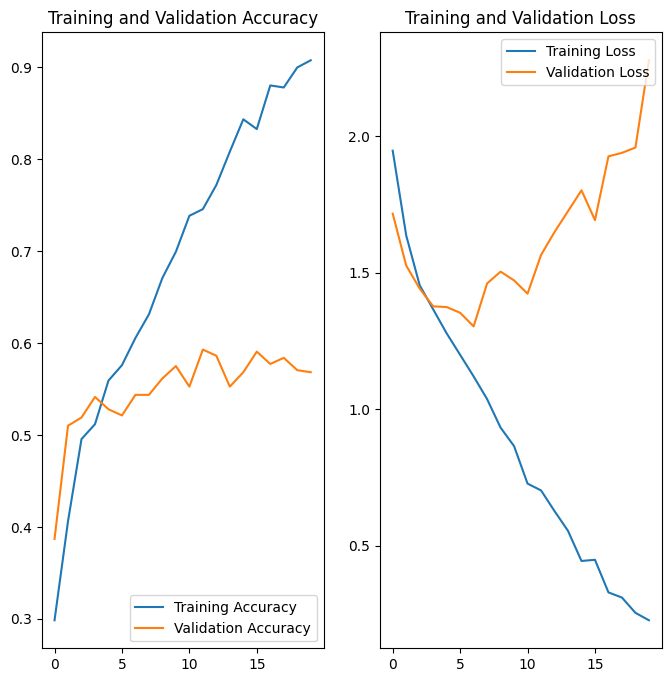

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observations:***

1. The model's training accuracy shows a steady increase of upto 90%, while validation accuracy remains consistently around 56%.

2. A high training accuracy suggests the model has effectively captured the noise within the data. However, its poor performance on validation data indicates a lack of generalizability.

3. These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for traini 2ndng the model.

### **Augmentation Strategy**

In [16]:
# After analysing the model fit history for presence of underfit or overfit, choosing an appropriate data augumentation strategy.
# Your code goes here

augmentation_data = models.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

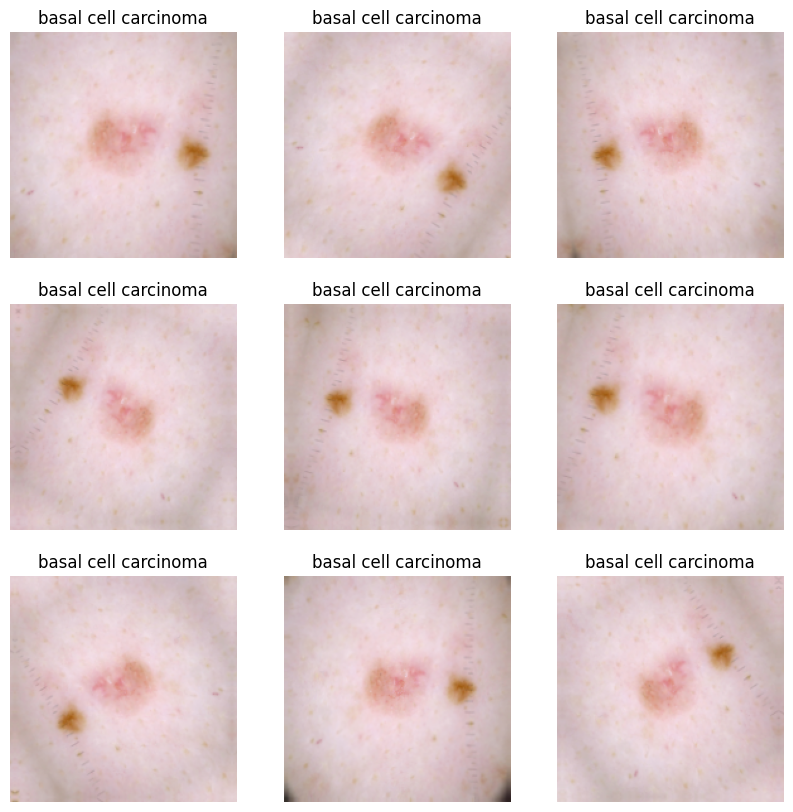

In [17]:
# Visualizing the augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### **Model Building & training on the augmented data (2nd Model)**

In [18]:
## Used Dropout layer as there is an evidence of overfitting in the first model

model = models.Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(num_classes)
])

### Compiling the model

In [19]:
## compiling

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
%%time
#training your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.1945 - loss: 2.2474 - val_accuracy: 0.3423 - val_loss: 1.8398
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 781ms/step - accuracy: 0.4278 - loss: 1.6621 - val_accuracy: 0.4787 - val_loss: 1.6012
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4752 - loss: 1.5377 - val_accuracy: 0.4899 - val_loss: 1.5122
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 897ms/step - accuracy: 0.5169 - loss: 1.3805 - val_accuracy: 0.4497 - val_loss: 1.5660
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 612ms/step - accuracy: 0.5120 - loss: 1.4085 - val_accuracy: 0.5347 - val_loss: 1.3874
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 496ms/step - accuracy: 0.5273 - loss: 1.3053 - val_accuracy: 0.5101 - val_loss: 1.5213
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 470ms/step - accuracy: 0.5549 - loss: 1.3043 - val_accuracy: 0.5391 - val_loss: 1.3461
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 458ms/step - accuracy: 0.5545 - loss: 1.2510 - val_accuracy: 

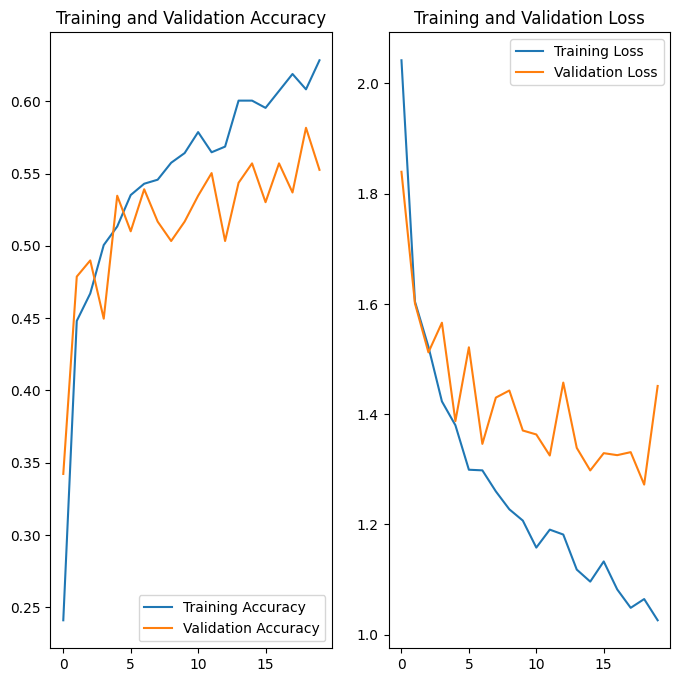

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observations:***

1. By leveraging augmented data, overfitting has been effectively addressed.

2. The training and validation accuracy of the aforementioned model fall within a similar range.

3. Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.

#### **Class Distribution.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [23]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('\\Users\\rakes\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('\\Users\\rakes\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis'), ('\\Users\\rakes\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025825.jpg', 'actinic keratosis'), ('\\Users\\rakes\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025953.jpg', 'actinic keratosis'), ('\\Users\\rakes\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025957.jpg', 'actinic keratosis')]


In [24]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,\Users\rakes\Downloads\CNN_assignment\Skin can...,actinic keratosis
1,\Users\rakes\Downloads\CNN_assignment\Skin can...,actinic keratosis
2,\Users\rakes\Downloads\CNN_assignment\Skin can...,actinic keratosis
3,\Users\rakes\Downloads\CNN_assignment\Skin can...,actinic keratosis
4,\Users\rakes\Downloads\CNN_assignment\Skin can...,actinic keratosis


In [25]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

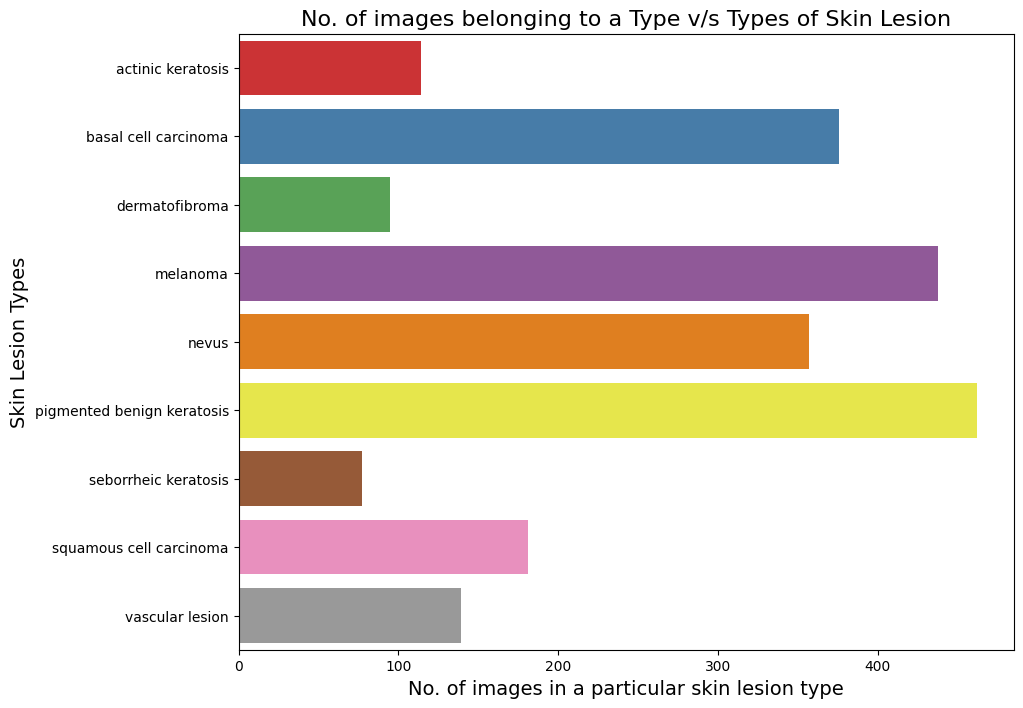

In [26]:
# Visualize the distribution of classes using a countplot

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df, palette="Set1")
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [27]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

Label                     
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64

***Observations:***

1. This is a pure evidence of class imbalance

2. The class **"seborrheic keratosis"** is of the smallest proportion of samples, approximately **3.44%**.

3. **"Pigmented benign keratosis"** and **"melanoma"** significantly outweigh other classes, representing approximately **20.63%** and **19.56%** of the data, respectively.

### **Handling class imbalance**


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [28]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to \Users\rakes\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18D88520890>: 100%|██████████| 500/500 [00:04<00:00, 107.23 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to \Users\rakes\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18D8530B250>: 100%|██████████| 500/500 [00:04<00:00, 107.63 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to \Users\rakes\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18D88831F90>: 100%|██████████| 500/500 [00:04<00:00, 103.36 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to \Users\rakes\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1936x1296 at 0x18D88431510>: 100%|██████████| 500/500 [00:36<00:00, 13.80 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to \Users\rakes\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x18D856917D0>: 100%|██████████| 500/500 [00:40<00:00, 12.23 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to \Users\rakes\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18D89B628D0>: 100%|██████████| 500/500 [00:07<00:00, 64.79 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to \Users\rakes\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x18D88866F50>: 100%|██████████| 500/500 [00:17<00:00, 27.92 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to \Users\rakes\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18D8576CBD0>: 100%|██████████| 500/500 [00:10<00:00, 45.47 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to \Users\rakes\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18D8582C490>: 100%|██████████| 500/500 [00:07<00:00, 70.19 Samples/s]                  


#### Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [29]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['\\Users\\rakes\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_688e41c0-64c9-4fb1-abb9-6c74e36b065d.jpg',
 '\\Users\\rakes\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_96ad5516-7cda-4d18-90d7-ca2bccd0a986.jpg',
 '\\Users\\rakes\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9f03fa06-2f30-414b-98e0-aaa2441799d3.jpg',
 '\\Users\\rakes\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b8573383-4dab-4d16-8928-3256d8de5302.jpg',
 '\\Users\\rakes\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df,df2])
new_df.shape

(6739, 2)

In [34]:
# View the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,\Users\rakes\Downloads\CNN_assignment\Skin can...,actinic keratosis
1,\Users\rakes\Downloads\CNN_assignment\Skin can...,actinic keratosis
2,\Users\rakes\Downloads\CNN_assignment\Skin can...,actinic keratosis
3,\Users\rakes\Downloads\CNN_assignment\Skin can...,actinic keratosis
4,\Users\rakes\Downloads\CNN_assignment\Skin can...,actinic keratosis


In [35]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

In [36]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

Label
pigmented benign keratosis    14.28
melanoma                      13.92
basal cell carcinoma          13.00
nevus                         12.72
squamous cell carcinoma       10.11
vascular lesion                9.48
actinic keratosis              9.11
dermatofibroma                 8.83
seborrheic keratosis           8.56
Name: proportion, dtype: float64

#### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [38]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Model Building & training on the rectified class imbalance data (3rd Model)**

In [40]:
## Architecture

#Sequential allows you to create models layer-by-layer
model3 = models.Sequential()

model3.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model3.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model3.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model3.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(64,activation='relu'))

#Dropout layer with 12% Fraction of the input units to drop.
model3.add(layers.Dropout(0.12))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model3.add(layers.Dense(len(class_names),activation='softmax'))

model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     1,638,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,633 (6.34 MB)

 Trainable params: 1,662,633 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the model

In [41]:
### Todo, choose an appropirate optimiser and loss function
model3.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Training the model

In [42]:
epochs = 40
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 73s 407ms/step - accuracy: 0.2948 - loss: 1.8806 - val_accuracy: 0.3912 - val_loss: 1.6255
Epoch 2/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 75s 440ms/step - accuracy: 0.4409 - loss: 1.4659 - val_accuracy: 0.4959 - val_loss: 1.3606
Epoch 3/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 70s 413ms/step - accuracy: 0.5076 - loss: 1.3067 - val_accuracy: 0.5568 - val_loss: 1.1982
Epoch 4/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 72s 427ms/step - accuracy: 0.5563 - loss: 1.1870 - val_accuracy: 0.5471 - val_loss: 1.2742
Epoch 5/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 422ms/step - accuracy: 0.5974 - loss: 1.0560 - val_accuracy: 0.6184 - val_loss: 1.0530
Epoch 6/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 374ms/step - accuracy: 0.6352 - loss: 0.9406 - val_accuracy: 0.6429 - val_loss: 0.9692
Epoch 7/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 369ms/step - accuracy: 0.6871 - loss: 0.8315 - val_accuracy: 0.7008 - val_loss: 0.8850
Epoch 8/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 369ms/step - accuracy: 0.7294 - loss: 0

#### Visualize the model results

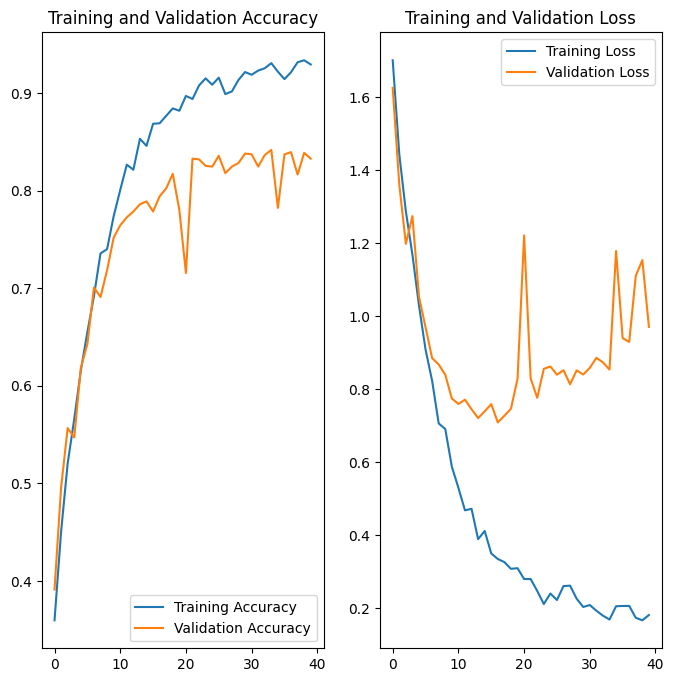

In [43]:
# Plot the training curves

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:
1. The ultimate model (3rd model) showcases well-balanced performance, displaying no signs of underfitting or overfitting.

2. The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.
 
3. Following 40 epochs, the final model attains an accuracy of 93% on the training set and approximately 83% on the validation set.
 
4. The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

### Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


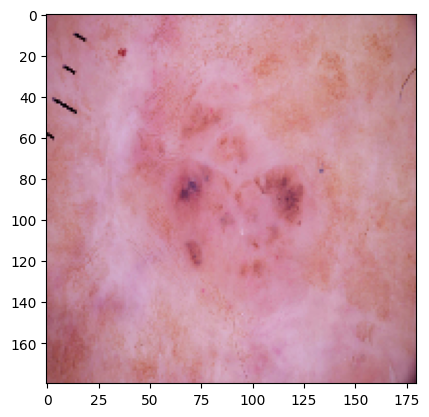

In [45]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model3.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)